In [1]:
import argparse
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import read_sdf, write_sdf, rm_radical, sa, qed, logp, write_pkl, mol_with_atom_index, remove_atom_indices
from rdkit import Chem
import random
from coati.generative.molopt import gradient_opt
from coati.generative.coati_purifications import embed_smiles
from functools import partial
from torch.nn.functional import sigmoid
import torch.nn.functional as F
import numpy as np

arg_parser = argparse.ArgumentParser(description='molecular optimization on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = 'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--noise', type=float, default=0.3)
args = arg_parser.parse_args([])


# define the model
def get_prop(v, model, normalize=False):
    '''
    Get the predicted property of a molecule on the chemical space.
    Input:
        model: the model to use
        v: the molecular embedding # (1, 1024)
    '''
    prop = model(v.unsqueeze(0)).mean
    if normalize:
        prop = sigmoid(prop)
    return prop

def read_txt(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

In [2]:
# model loading
DEVICE = torch.device(args.device)
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [3]:
fgfr1_model_data = 'model_ckpts/conditions/fgfr1_3138_data.pt'
fgfr1_model_ckp = 'model_ckpts/conditions/fgfr1_3146_regression_pic50.pkl'
fgfr1_model_data = torch.load(fgfr1_model_data)
fgfr1_model, _= basic_due(fgfr1_model_data, y_field = 'pic50', load_as=fgfr1_model_ckp)

fgfr3_model_data = 'model_ckpts/conditions/fgfr3_1896_data.pt'
fgfr3_model_ckp = 'model_ckpts/conditions/fgfr3_1896_regression_pic50.pkl'
fgfr3_model_data = torch.load(fgfr3_model_data)
fgfr3_model, _= basic_due(fgfr3_model_data, y_field = 'pic50', load_as=fgfr3_model_ckp)

get_fgfr1 = partial(get_prop, model=fgfr1_model)
get_fgfr3 = partial(get_prop, model=fgfr3_model)

/home/haotian/software/miniconda3/envs/ecloud/lib/python3.9/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [173]:
init_mol = read_sdf('./examples/FGFR3/fgfr3_ligand_covalent.sdf')[0]
init_smi = Chem.MolToSmiles(init_mol)

objective_fcn = lambda v: -10 * get_fgfr3(v) + get_fgfr1(v)

all_mols = []

init_emb_vec = embed_smiles(init_smi, encoder, tokenizer).to(DEVICE)
traj = gradient_opt(
    init_emb_vec = init_emb_vec,
    objective_fcn = objective_fcn,  # the constraints below will be added to this.
    encoder = encoder,
    tokenizer = tokenizer,
    add_bump=False,
    constraint_functions={},  # enforced to == 0 by lagrange multipliers.
    log_functions={
        'fgfr1': get_fgfr1,
        'fgfr3': get_fgfr3,
    },  # These log functions will get appended to the history list-dict returned.
    nsteps=100,
    save_traj_history=None,
    save_every=1,
    project_every=15,
    report=True,
)
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
activity = [-i['activity'] for i in traj]


0: dV 0.000e+00 loss:-54.10 activity:-54.10 bump_term:0.00 const_term:0.00 fgfr1:7.15 fgfr3:6.41 
1: dV 1.795e-01 loss:-73.77 activity:-73.77 bump_term:0.00 const_term:0.00 fgfr1:7.13 fgfr3:8.12 
2: dV 1.970e-01 loss:-86.29 activity:-86.29 bump_term:0.00 const_term:0.00 fgfr1:7.14 fgfr3:9.37 
3: dV 7.173e-02 loss:-88.38 activity:-88.38 bump_term:0.00 const_term:0.00 fgfr1:7.12 fgfr3:9.59 
4: dV 5.502e-02 loss:-90.12 activity:-90.12 bump_term:0.00 const_term:0.00 fgfr1:7.02 fgfr3:9.68 
5: dV 4.567e-02 loss:-91.22 activity:-91.22 bump_term:0.00 const_term:0.00 fgfr1:7.00 fgfr3:9.77 
6: dV 3.568e-02 loss:-91.11 activity:-91.11 bump_term:0.00 const_term:0.00 fgfr1:7.07 fgfr3:9.87 
7: dV 3.302e-02 loss:-91.23 activity:-91.23 bump_term:0.00 const_term:0.00 fgfr1:6.94 fgfr3:9.89 
8: dV 2.819e-02 loss:-92.30 activity:-92.30 bump_term:0.00 const_term:0.00 fgfr1:6.90 fgfr3:9.90 
9: dV 2.620e-02 loss:-91.59 activity:-91.59 bump_term:0.00 const_term:0.00 fgfr1:6.87 fgfr3:9.95 
10: dV 2.730e-02 los

In [6]:
from coati.utils.chem import read_pkl
traj = read_pkl('/home/haotian/Molecule_Generation/MG/backupECloud/EcloudGen-COATI/examples/FGFR3/non-covalent_start_100tarj.pkl')
mols_list = read_sdf('./examples/FGFR3/fgfr_design.sdf')

In [9]:
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]

In [13]:
Chem.MolToSmiles(mols_list[3])

'CNC(=O)NC1CCCC(c2nc3ccccc3n2CC(=O)NCC(C)(O)c2ccco2)C1'

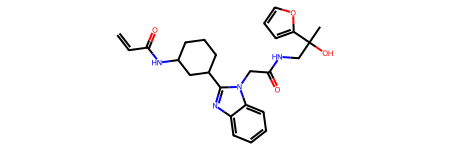

In [12]:
amide2amine(mols_list[3])

In [11]:
from rdkit.Chem import AllChem
def amide2amine(mol):
    # !@ represent the bond that is not in the ring
    rxn = AllChem.ReactionFromSmarts("[C:1](=O)!@[N:2]!@[CH3:3]>>[C:1](=O)[C:2]=[C:3]")
    ps = rxn.RunReactants((mol,))
    if len(ps) == 0:
        return None
    return ps[0][0]

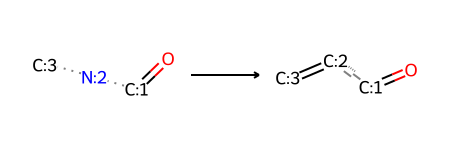

In [175]:
AllChem.ReactionFromSmarts("[C:1](=O)!@[N:2]!@[CH3:3]>>[C:1](=O)[C:2]=[C:3]")

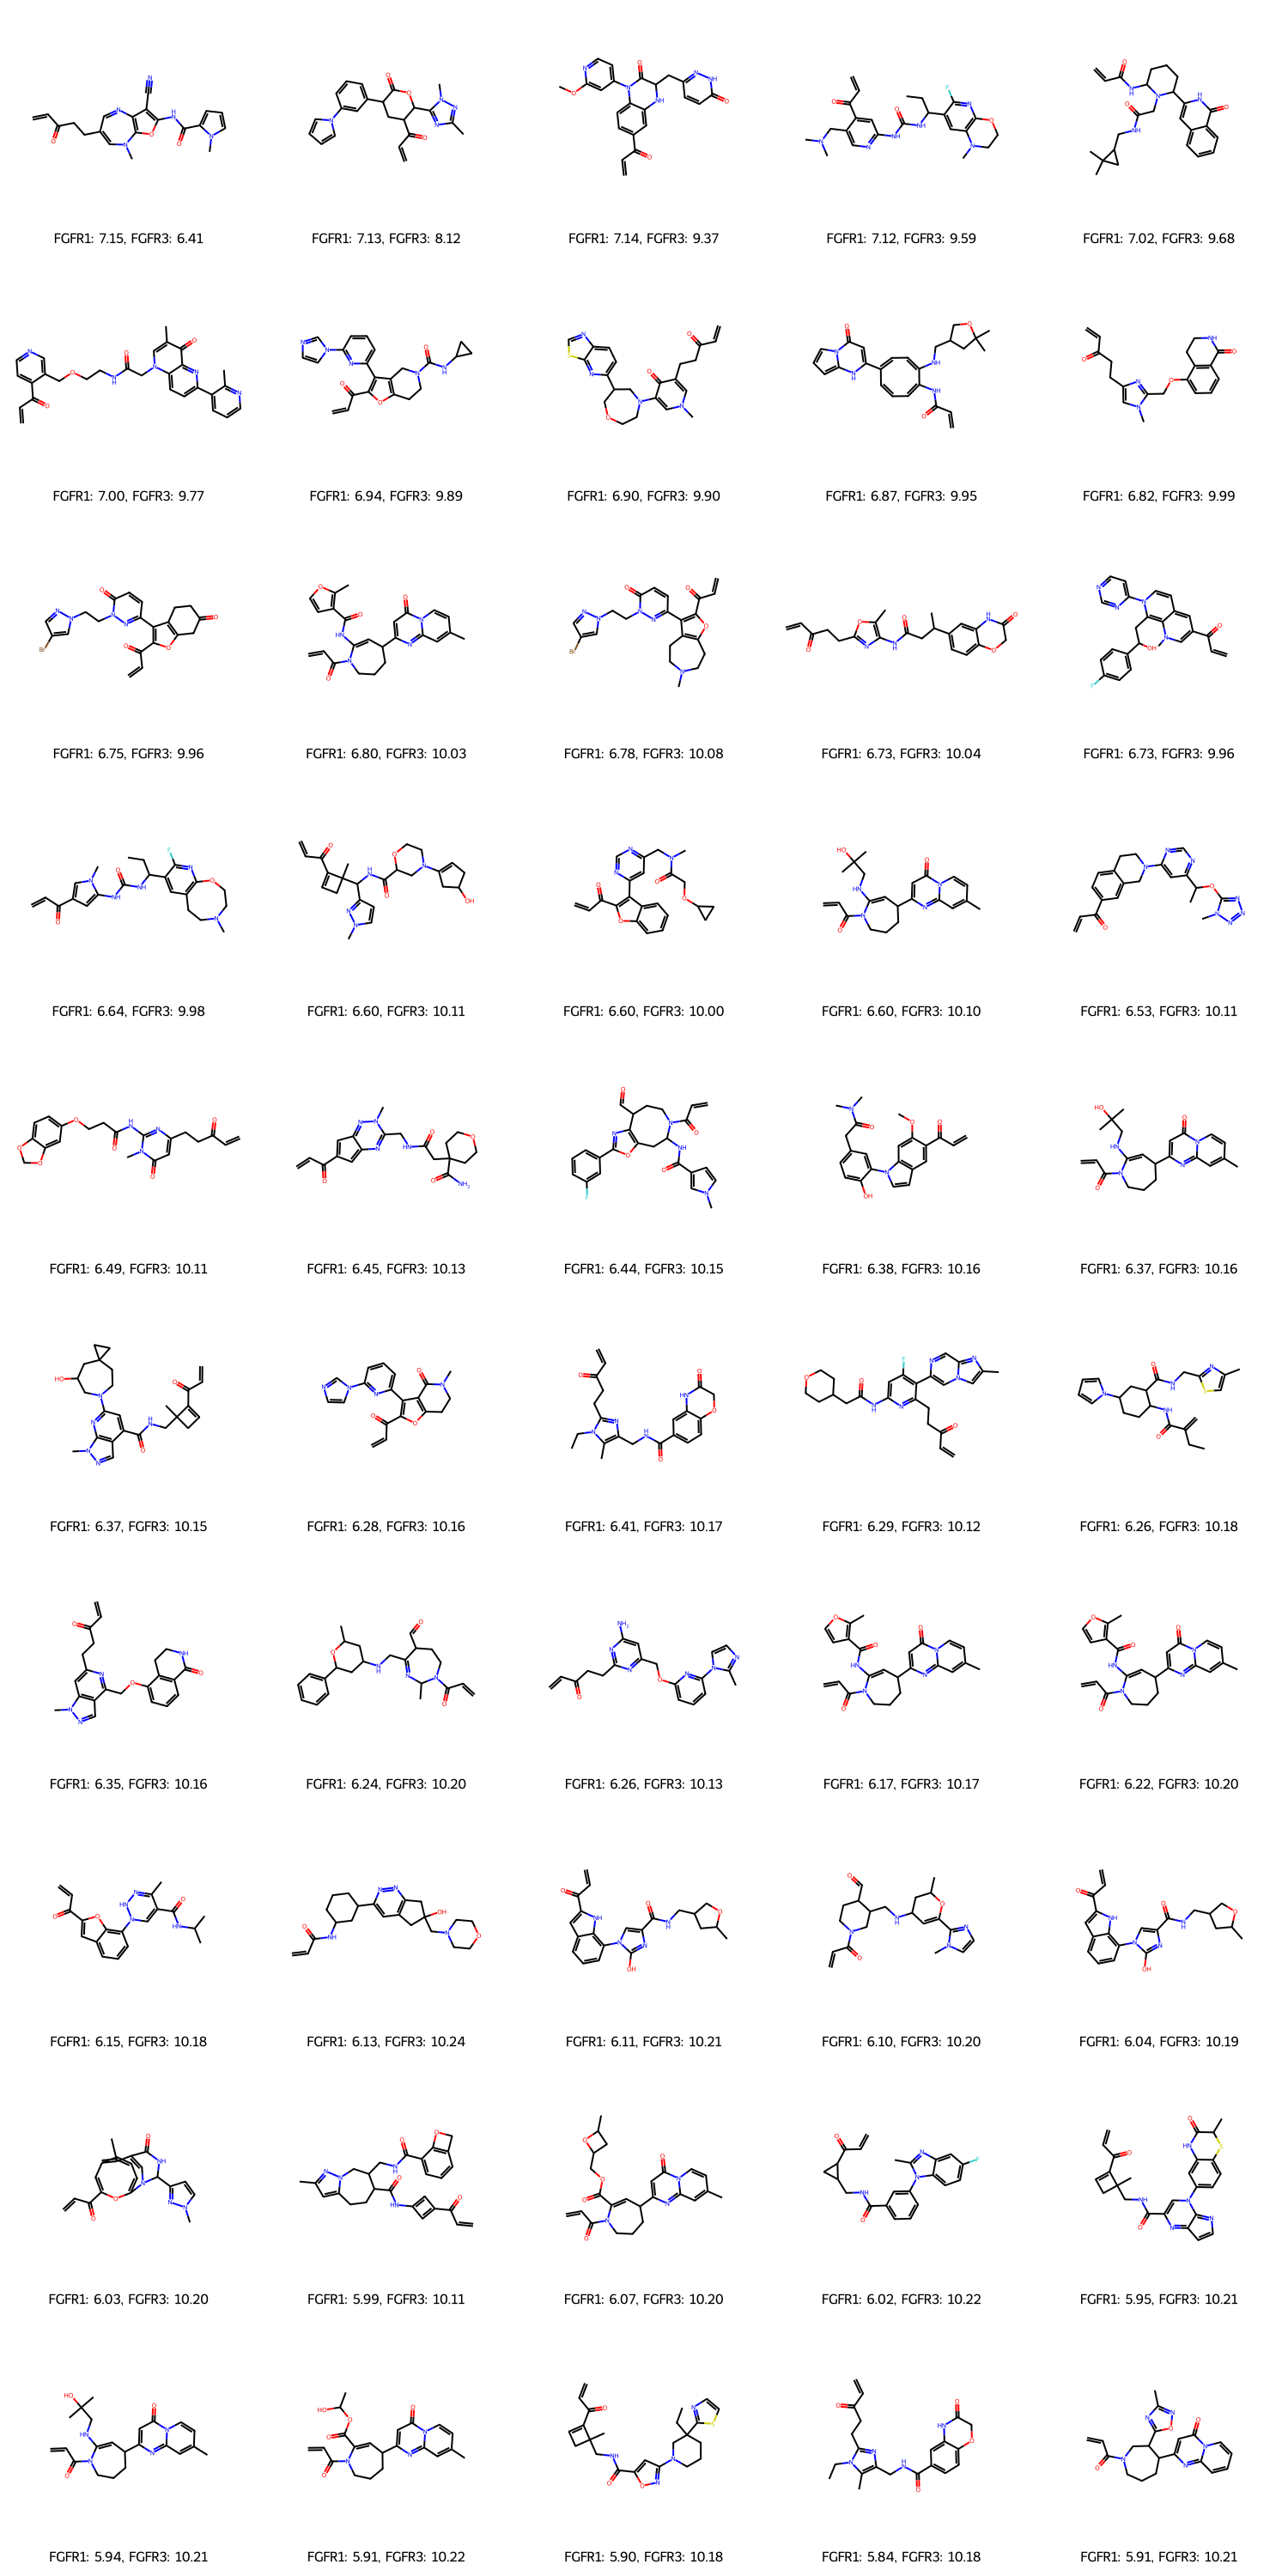

In [188]:
from rdkit.Chem import Draw
mols_list_ = [amide2amine(mol) for mol in mols_list[1:]]
binding = [(i['fgfr1'], i['fgfr3']) for i in traj[1:]]
show_mol = []
show_binding = []
for i in range(len(mols_list_)):
    if mols_list_[i] is not None:
        show_mol.append(mols_list_[i])
        show_binding.append(binding[i])

Draw.MolsToGridImage(show_mol, molsPerRow=5, subImgSize=(300, 300), legends=[f'FGFR1: {i[0]:.2f}, FGFR3: {i[1]:.2f}' for i in show_binding])

In [191]:
saved_mol = []
for i in range(len(show_mol)):
    mol = show_mol[i]
    binding_info = show_binding[i]
    mol.SetProp('FGFR1', str(binding_info[0]))
    mol.SetProp('FGFR3', str(binding_info[1]))
    saved_mol.append(mol)

In [192]:
write_sdf(saved_mol, './examples/FGFR3/fgfr_design.sdf')